간단한 이론은 ppt 참고 

# 4.5 Weight Decay 

### 4.5.2. High-Dimensional Linear Regression 

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

We choose our label to be a linear function of our inputs, corrupted by Gaussian noise with zero mean and standard deviation 0.01. To make the effects of overfitting pronounced, we can increase the dimensionality of our problem to d=200 and work with a small training set containing only 20 examples.

-> overfitting 되어 있는 다항식 만들어주기 

In [3]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise"""
    X = d2l.normal(0, 1, (num_examples, len(w)))
    y = d2l.matmul(X, w) + b
    y += d2l.normal(0, 0.01, y.shape) # = noise 에 해당 
    return X, d2l.reshape(y, (-1, 1))


n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

# truw_w = weigh, true_b = bias 

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size) # dataloader 
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [25]:
# Initializing model parameters 
# 이는 알고리즘은 학습 중인 데이터의 입력에서 출력까지 특정 매핑 기능에 좋은 weight 집단을 찾기 위해서 임의성을 사용해서 진행하기 때문 
# 하는 이유는 학습을 위해 확률적 경사 하강법을 사용하는데 이 확률적 최적화 알고리즘은 탐색의 시작점을 선택하고 탐색을 진행할 때 임의성을 사용 
# 그래서 네트워크의 가중치가 작은 임의값 (0-1에서와 같이 0에 가까운)으로 초기화되어야 됨. 

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# define L2 norm penalty 
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

# train loop 
def train(lambd): # lambd = weight decay 
    w, b = init_params()
    net = lambda X: d2l.linreg(X, w, b) # d2l.matmul(X, w) + b
    loss = d2l.squared_loss # (y_hat - d2l.reshape(y, y_hat.shape)) ** 2 / 2
    num_epochs = 100 
    lr = 0.003

    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)

    print('L2 norm of w:', torch.norm(w).item())

In [28]:
train(lambd=0)

L2 norm of w: 13.211760520935059


In [30]:
train(lambd=3)

L2 norm of w: 0.3699600100517273


### 4.5.4. Concise Implementation 

In [8]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
    print('L2 norm of w:', net[0].weight.norm().item())

train_concise(0)

L2 norm of w: 13.748948097229004


In [12]:
import torch.optim as optim 

def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))

    for param in net.parameters():
        param.data.normal_()

    loss = nn.MSELoss(reduction='none')
    NUM_EPOCH = 100
    LEARNING_RATE = 0.003

    # The bias parameter has not decayed
    optimizer = torch.optim.SGD(net.parameters(),
                              lr = LEARNING_RATE, 
                              weight_decay=wd)

    for epoch in range(NUM_EPOCH):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            optimizer.step()
    print('L2 norm of w:', net[0].weight.norm().item())

train_concise(0)

L2 norm of w: 14.208196640014648


In [13]:
train_concise(3)

L2 norm of w: 0.3780629336833954


In [18]:
net = nn.Sequential(nn.Linear(num_inputs, 1))
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-1.4065e-02,  4.8810e-02, -4.0941e-02, -4.3291e-02, -4.1257e-02,
          5.3040e-02,  5.1180e-02,  2.7170e-02, -7.0623e-02,  1.0212e-02,
          3.6267e-02, -1.6418e-02,  4.3491e-02, -3.0057e-02,  4.3894e-02,
          6.9103e-02, -1.0991e-02,  2.1794e-02,  5.7717e-02,  6.7122e-02,
         -3.3881e-02,  1.8318e-02,  6.0201e-03, -5.8054e-03,  5.6544e-02,
         -2.1596e-02, -5.5976e-02, -5.7551e-02, -6.9360e-02,  2.0538e-02,
         -6.3439e-02, -5.5260e-02,  4.1454e-02,  5.8600e-02, -6.4535e-02,
         -5.4619e-02, -6.5109e-02,  5.3433e-02,  1.3829e-02, -4.6517e-02,
          4.3468e-02, -3.7508e-02, -1.3235e-02,  3.0167e-02,  5.5978e-02,
         -9.8396e-03, -1.0833e-02, -6.6752e-02, -4.7607e-02, -1.1066e-04,
         -4.9800e-02,  2.3099e-02, -6.7289e-02, -1.5771e-02,  5.8324e-02,
         -5.4380e-02, -1.4342e-02,  1.0452e-03,  5.9089e-02, -3.3318e-02,
         -2.0679e-02,  5.5236e-02,  2.7355e-02,  7.0174e-02,  1.8479e-02,
         -4.1596

# 4.6 Dropout 

- Good predicitve model shoould perform well on unseen data. 
- Sumplicity 

### 4.6.2 Robustness through Perturbations 

- In 1995, Christopher Bishop formalized this idea when he proved that training with input noise is equivalent to Tikhonov regularization [Bishop, 1995]. This work drew a clear mathematical connection between the requirement that a function be smooth (and thus simple), and the requirement that it be resilient to perturbations in the input.

- Then, in 2014, Srivastava et al. [Srivastava et al., 2014] developed a clever idea for how to apply Bishop’s idea to the internal layers of a network, too. Namely, they proposed to inject noise into each layer of the network before calculating the subsequent layer during training. They realized that when training a deep network with many layers, injecting noise enforces smoothness just on the input-output mapping.

- Their idea, called dropout, involves injecting noise while computing each internal layer during forward propagation, and it has become a standard technique for training neural networks. The method is called dropout because we literally drop out some neurons during training. Throughout training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes in each layer before calculating the subsequent layer.

- The authors argue that neural network overfitting is characterized by a state in which each layer relies on a specifc pattern of activations in the previous layer

- """The key challenge then is how to inject this noise. One idea is to inject the noise in an unbiased manner so that the expected value of each layer—while fixing the others—equals to the value it would have taken absent noise."""


### 4.6.3. Dropout in Practice 

- 모델에 dropout 적용한 모습. 결국 p 값을 우리가 얼만큼 설정해주는 지에 따라서 위에 식 h/(1-p) 가 otherwise로 지칭되어 있으니 그 특정 비율로 남게 되는것 
- Typically, we disable dropout at test time. -> pytorch model.train(), model.eval()

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch} / {num_epochs}')
    print('-'*10)

    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

### 4.6.4. Implementation from Scratch

In [7]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1 # dropout 값 0~1 사이로 조건 설정 
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float() # intermediate layer 
    return mask * X / (1.0 - dropout) # 위에 식과 동일 h = mask * X, 1 - p = (1.0 - dropout)

X= torch.arange(16, dtype = torch.float32).reshape((2, 8)) # X (0에서부터 16까지 shape 2,8)

print(X)



tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])


In [5]:
print(dropout_layer(X, 0.)) # dropout ==0: return X 

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])


In [14]:

import random
import numpy as np
import os
import torch

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    # torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore


seed_everything(42)

In [15]:
print(dropout_layer(X, 0.5))

tensor([[ 0.,  2.,  0.,  6.,  0., 10.,  0., 14.],
        [16.,  0., 20., 22., 24., 26., 28.,  0.]])


이제 random한 비율로 0으로 대체되는 것을 확인 가능 

In [13]:
print(dropout_layer(X, 0.5))

tensor([[ 0.,  2.,  0.,  6.,  0., 10.,  0., 14.],
        [16.,  0., 20., 22., 24., 26., 28.,  0.]])


In [7]:
print(dropout_layer(X, 1.)) # if dropout == 1: return torch.zeros_list(X)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [17]:
# We define an MLP with two hidden layers containing 256 units each.

# model parameters
NUM_INPUTS = 784 
NUM_OUTPUTS = 10
NUM_HIDDENS1 = 512
NUM_HIDDENS2 = 512

# dropout layer 
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1 # dropout 값 0~1 사이로 조건 설정 
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout) # 위에 식과 동일 h = mask * X, 1 - p = (1.0 - dropout)

# define model 
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)

        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
            
        out = self.lin3(H2)
        return out


net = Net(NUM_INPUTS, NUM_OUTPUTS, NUM_HIDDENS1, NUM_HIDDENS2)


In [10]:
net

Net(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=784, bias=True)
  (relu): ReLU()
)

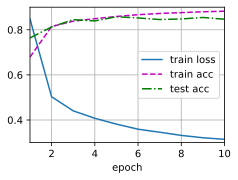

In [18]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

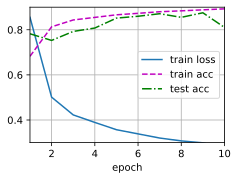

In [29]:
dropout1, dropout2 = 0, 0

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)

        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
            
        out = self.lin3(H2)
        return out


net = Net(NUM_INPUTS, NUM_OUTPUTS, NUM_HIDDENS1, NUM_HIDDENS2)

num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 4.6.5. Concise Implementation 

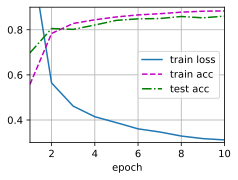

In [22]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
NUM_INPUTS = 784 
NUM_OUTPUTS = 10
NUM_HIDDENS1 = 512
NUM_HIDDENS2 = 512

import torch.nn.functional as F

class NN(nn.module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self,x):
        x = F.relu(self.l1(x))
        x = self.dropout(x)

        x - F.relu(self.l2(x))
        x = self.dropout(x)

        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x 
